In [1]:
from __future__ import annotations
import random,math,torch,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from functools import partial

from miniai.datasets import *
from miniai.learner import *
     

import torch.nn.functional as F,matplotlib as mpl
from pathlib import Path
from operator import attrgetter,itemgetter
from contextlib import contextmanager

from torch import tensor,nn,optim
import torchvision.transforms.functional as TF
from datasets import load_dataset

from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['figure.constrained_layout.use'] = True

import logging
logging.disable(logging.WARNING)

In [2]:
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [3]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)
bs = 1024

@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
dv = dls.valid

In [4]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

def cnn_layers():
    return [
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        nn.Flatten()]

In [5]:
from torcheval.metrics import MulticlassAccuracy


In [6]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

In [7]:
def fit(model, epochs=1, xtra_cbs=None):
    learn = Learner(model, dls, loss_func=F.cross_entropy, lr=0.6, cbs=cbs+fc.L(xtra_cbs))
    learn.fit(epochs)
    return learn

accuracy,loss,epoch,train
0.153,2.301,0,train
0.269,2.117,0,eval


/home/metao/fastai2023/part2/.conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


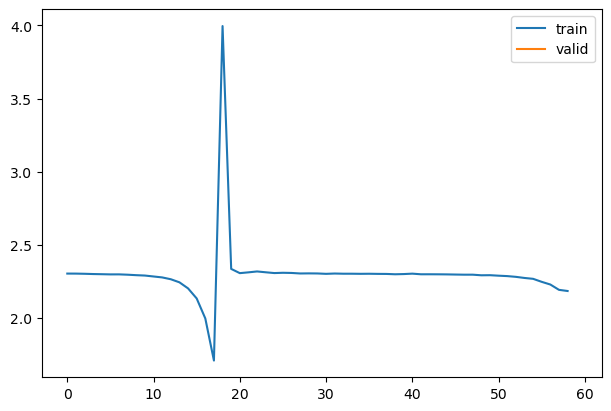

In [8]:
set_seed(1)
learn = fit(nn.Sequential(*cnn_layers()))

In [9]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(to_cpu(x).mean())
            self.act_stds [i].append(to_cpu(x).std ())
        return x
    
    def __iter__(self): return iter(self.layers)

accuracy,loss,epoch,train
0.159,2.296,0,train
0.317,1.997,0,eval


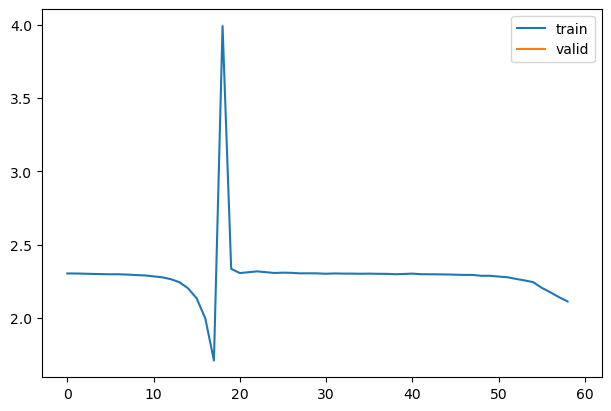

In [10]:
set_seed(1)
model = SequentialModel(*cnn_layers())
learn = fit(model)

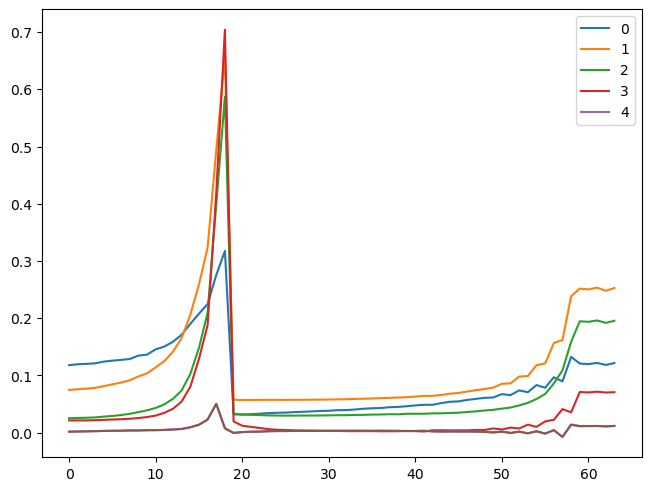

In [11]:
for l in model.act_means: plt.plot(l)
plt.legend(range(5));
     

In [12]:
class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

In [13]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())

In [14]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

In [15]:
hooks = [Hook(l, append_stats) for l in model[:5].children()]

accuracy,loss,epoch,train
0.157,2.300,0,train
0.199,2.100,0,eval


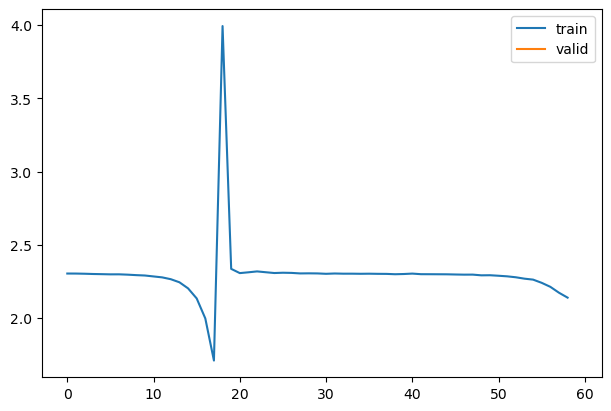

In [16]:
learn = fit(model)

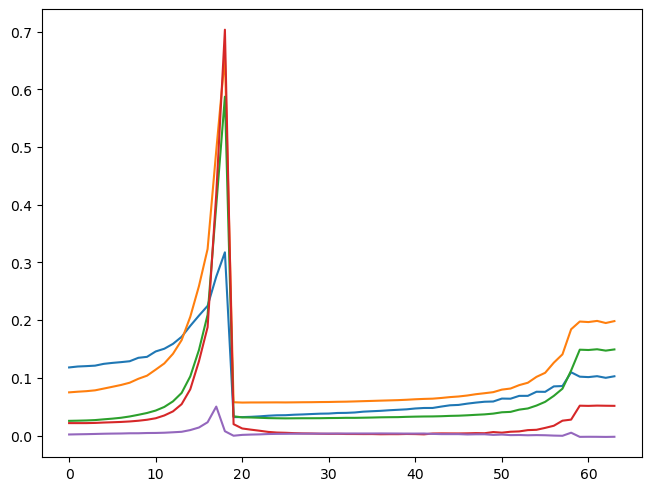

In [17]:
for h in hooks:
    plt.plot(h.stats[0])

In [18]:
class Hooks(list):
    def __init__(self, ms, f): super().__init__([Hook(m,f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__(self,*args): self.remove()
    def __del__(self): self.remove()
    def __delitem__(self,i):
        self[i].remove()
        super().__delitem__(i)
    def remove(self):
        for h in self: h.remove()

In [19]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

accuracy,loss,epoch,train
0.157,2.301,0,train
0.199,2.148,0,eval


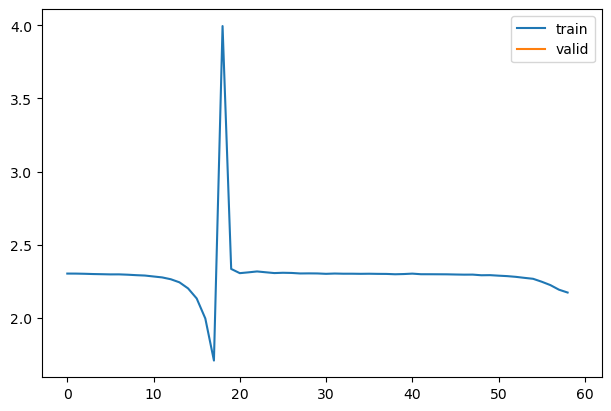

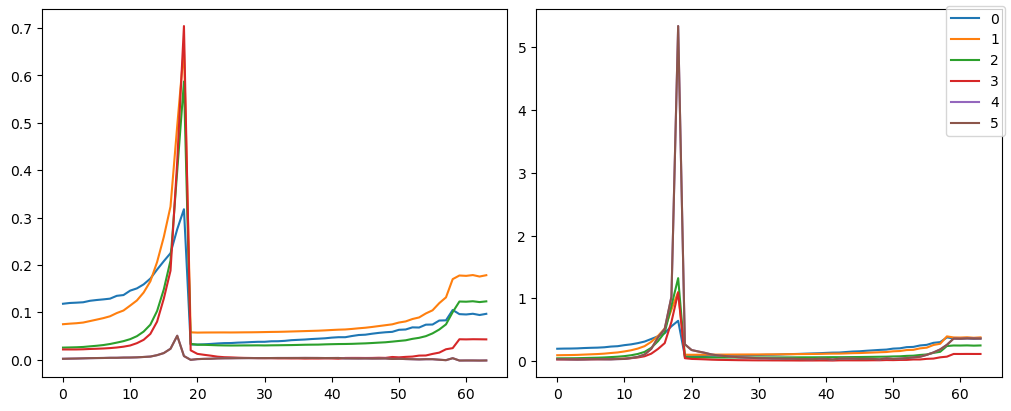

In [20]:
with Hooks(model, append_stats) as hooks:
    fit(model)
    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    for h in hooks:
        for i in 0,1:
            axes[i].plot(h.stats[i])
    fig.legend(range(6))

In [21]:
class HooksCallback(Callback):
    def __init__(self, hookfunc, mod_filter=fc.noop, on_train=True, on_valid=False, mods=None):
        fc.store_attr()
        super().__init__()
    
    def before_fit(self, learn):
        if self.mods: mods=self.mods
        else: mods = fc.filter_ex(learn.model.modules(), self.mod_filter)
        self.hooks = Hooks(mods, partial(self._hookfunc, learn))

    def _hookfunc(self, learn, *args, **kwargs):
        if (self.on_train and learn.training) or (self.on_valid and not learn.training): self.hookfunc(*args, **kwargs)

    def after_fit(self, learn): self.hooks.remove()
    def __iter__(self): return iter(self.hooks)
    def __len__(self): return len(self.hooks)

In [31]:
mods = fc.filter_ex(model.modules(), None)

In [36]:
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))

accuracy,loss,epoch,train
0.155,2.300,0,train
0.276,2.096,0,eval


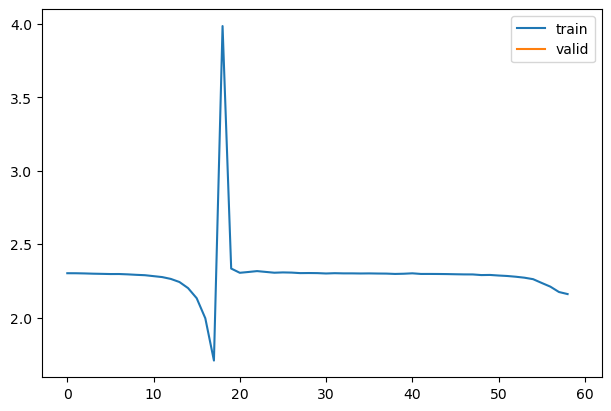

In [37]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
learn = fit(model, xtra_cbs=[hc]);

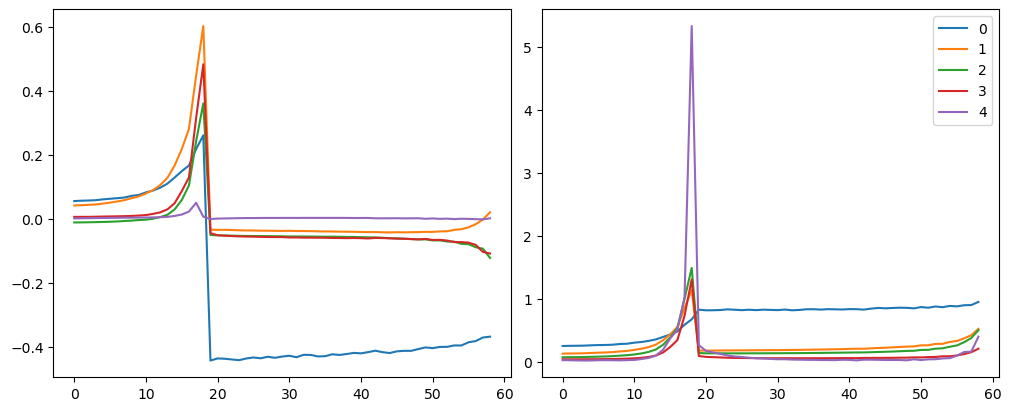

In [38]:
fig,axs = plt.subplots(1,2, figsize=(10,4))
for h in hc:
    for i in 0,1: axs[i].plot(h.stats[i])
plt.legend(range(6));

In [42]:
class ActivationStats(HooksCallback):
    def __init__(self, mod_filter=fc.noop): super().__init__(append_stats, mod_filter)

    def color_dim(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flat, self):
            show_image(get_hist(h), ax, origin='lower')

    def dead_chart(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flatten(), self):
            ax.plot(get_min(h))
            ax.set_ylim(0,1)

    def plot_stats(self, figsize=(10,4)):
        fig,axs = plt.subplots(1,2, figsize=figsize)
        for h in self:
            for i in 0,1: axs[i].plot(h.stats[i])
        axs[0].set_title('Means')
        axs[1].set_title('Stdevs')
        plt.legend(fc.L.range(self))

In [43]:
astats = ActivationStats(fc.risinstance(nn.Conv2d))
     

accuracy,loss,epoch,train
0.158,2.296,0,train
0.357,1.947,0,eval


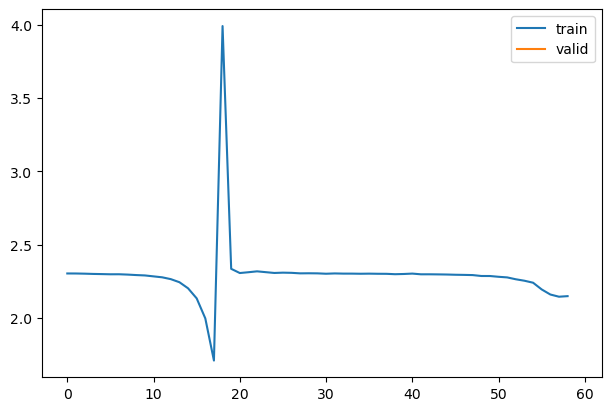

In [44]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[astats]);

IndexError: tuple index out of range

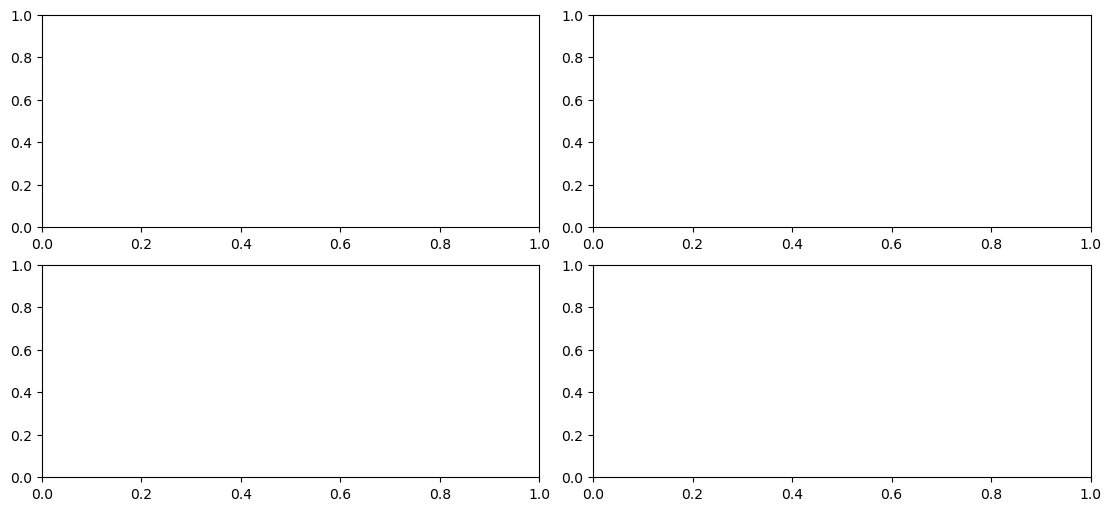

In [46]:
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()
astats.color_dim()

In [47]:
astats.hooks

In [48]:
class Test():
    def pr(self):
        print('hello')

In [49]:
Test().pr()

hello
